# **Preparing**

In [ ]:
from pathlib import Path
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, PandasTools
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams
from rdkit.Chem.Draw import IPythonConsole
from tqdm.auto import tqdm
tqdm.pandas()
os.chdir("./Data/")

# pip install scopy

In [ ]:
smiles = [
    "CCC1C(=O)N(CC(=O)N(C(C(=O)NC(C(=O)N(C(C(=O)NC(C(=O)NC(C(=O)N(C(C(=O)N(C(C(=O)N(C(C(=O)N(C(C(=O)N1)C(C(C)CC=CC)O)C)C(C)C)C)CC(C)C)C)CC(C)C)C)C)C)CC(C)C)C)C(C)C)CC(C)C)C)C",
    "CN1CCN(CC1)C2=C3C=CC=CC3=NC4=C(N2)C=C(C=C4)C",
    "CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC=CC=C(C)C=CC=C(C)C=CC2=C(CCCC2(C)C)C)C)C",
    "CCCCCC1=CC(=C(C(=C1)O)C2C=C(CCC2C(=C)C)C)O",
]
names = ["cyclosporine", "clozapine", "beta-carotene", "cannabidiol"]

,name,smiles,ROMol
0,cyclosporine,CCC1C(=O)N(CC(=O)N(C(C(=O)NC(C(=O)N(C(C(=O)NC(...,
1,clozapine,CN1CCN(CC1)C2=C3C=CC=CC3=NC4=C(N2)C=C(C=C4)C,
2,beta-carotene,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC=CC=C(C)C=CC=...,
3,cannabidiol,CCCCCC1=CC(=C(C(=C1)O)C2C=C(CCC2C(=C)C)C)O,

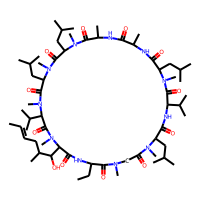
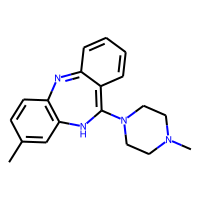
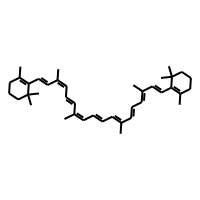
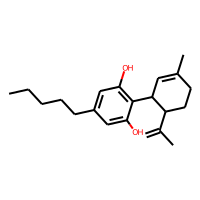

In [ ]:
molecules = pd.DataFrame({"name": names, "smiles": smiles})
PandasTools.AddMoleculeColumnToFrame(molecules, "smiles")
molecules

**Calculate descriptors**

In [ ]:
def calculate_descriptors(smiles):
    """
    Calculate Ro5-relevant chemical properties.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    pandas.Series
        Ro5-relevant chemical properties.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate Ro5-relevant chemical properties
    molecular_weight = Descriptors.ExactMolWt(molecule)
    n_hba = Descriptors.NumHAcceptors(molecule)
    n_hbd = Descriptors.NumHDonors(molecule)
    logp = Descriptors.MolLogP(molecule)
    tpsa = Descriptors.TPSA(molecule)
    return pd.Series(
        [molecular_weight, n_hba, n_hbd, logp, tpsa],
        index=["molecular_weight", "n_hba", "n_hbd", "logp", "tpsa"],
    )
    
# des = molecules["smiles"].progress_apply(calculate_descriptors)
# molecules = pd.concat([molecules, des], axis=1)
# des

# **Medicinal Chemistry Rules**

1. [QED](https://www.nature.com/articles/nchem.1243)
- A measure of drug-likeness based on the concept of desirability. QED is calculated by integrating the outputs of the desirability functions based on eight drug-likeness related properties, including MW, log P, NHBA, NHBD, PSA, Nrotb, the number of aromatic rings (NAr), and the number of alerts for undesirable functional groups. 
- Results interpretation: The mean QED is 0.67 for the attractive compounds, 0.49 for the unattractive compounds and 0.34 for the unattractive compounds considered too complex.

2. [SAscore](https://jcheminf.biomedcentral.com/articles/10.1186/1758-2946-1-8)
- Synthetic accessibility score is designed to estimate ease of synthesis of drug-like molecules, based on a combination of fragment contributions and a complexity penalty. The score is between 1 (easy to make) and 10 (very difficult to make). The synthetic accessibility score (SAscore) is calculated as a combination of two components: \text { SAscore }=\text { fragmentScore - complexityPenalty } SAscore = fragmentScore - complexityPenalty 
- Results interpretation: high SAscore: ≥ 6, difficult to synthesize; low SAscore: < 6, easy to synthesize

3. [Fsp3](https://pubs.acs.org/doi/10.1021/jm901241e)
- Fsp3, the number of sp3 hybridized carbons/total carbon count, is used to determine the carbon saturation of molecules and characterize the complexity of the spatial structure of molecules. It has been demonstrated that the increased saturation measured by Fsp3 and the number of chiral centers in the molecule increase the clinical success rate, which might be related to the increased solubility, or the fact that the enhanced 3D features allow small molecules to occupy more target space.
- Results interpretation: Fsp3 ≥ 0.42 is considered a suitable value.

4. [Lipinski Rule](https://www.sciencedirect.com/science/article/abs/pii/S0169409X00001290?via%3Dihub)
- Content: MW≤500; logP≤5; Hacc≤10; Hdon≤5
- Results interpretation: If two properties are out of range, a poor absorption or permeability is possible, one is acceptable.

5. [Pfizer Rule](https://www.sciencedirect.com/science/article/abs/pii/S0960894X08008500?via%3Dihub)
- Content: logP > 3; TPSA < 75
- Results interpretation: Compounds with a high log P (>3) and low TPSA (< 75) are likely to be toxic.

6. [GSK Rule](https://pubs.acs.org/doi/10.1021/jm701122q)
- Content: MW ≤ 400; logP ≤ 4
- Results interpretation: Compounds satisfying the GSK rule may have a more favorable ADMET profile.

7. [Golden Triangle](https://www.sciencedirect.com/science/article/abs/pii/S0960894X09011858?via%3Dihub)
- Content: 200 ≤MW ≤50; -2 ≤ logD ≤5     (logP)
- Results interpretation: Compounds satisfying the GoldenTriangle rule may have a more favourable ADMET profile.

8. [PAINS](https://pubs.acs.org/doi/10.1021/jm901137j)
- Pan Assay Interference Compounds (PAINS) is one of the most famous frequent hitters filters, which comprises 480 substructures derived from the analysis of FHs determined by six target-based HTS assay. By application of these filters, it is easier to screen false positive hits and to flag suspicious compounds in screening databases. One of the most authoritative medicine magazines Journal of Medicinal Chemistry even requires authors to provide the screening results with the PAINS alerts of active compounds when submitting manuscripts.


9. [ADMETlab 2.0](https://admetmesh.scbdd.com/explanation/index)

# **1. Ro5**

- Content: MW≤500; logP≤5; Hacc≤10; Hdon≤5; TPSA≤140
- Results interpretation: If two properties are out of range, a poor absorption or permeability is possible, one is acceptable.
- Empirical decision: < 2 violations：excellent (green)；≥2 violations: poor (red)

In [ ]:
def calculate_ro5_properties(smiles, fullfill = 4):
    """
    Test if input molecule (SMILES) fulfills Lipinski's rule of five.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.
    fullfill: int
        Number of rules fullfill RO5

    Returns
    -------
    bool
        Lipinski's rule of five compliance for input molecule.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate Ro5-relevant chemical properties
    molecular_weight = Descriptors.ExactMolWt(molecule)
    n_hba = Descriptors.NumHAcceptors(molecule)
    n_hbd = Descriptors.NumHDonors(molecule)
    logp = Descriptors.MolLogP(molecule)
    tpsa = Descriptors.TPSA(molecule)
    # Check if Ro5 conditions fulfilled
    conditions = [molecular_weight <= 500, n_hba <= 10, n_hbd <= 5, logp <= 5, tpsa <= 140]
    ro5_fulfilled = sum(conditions) >= fullfill
    # Return True if no more than one out of four conditions is violated
    # return pd.Series(
    #     [molecular_weight, n_hba, n_hbd, logp, tpsa, ro5_fulfilled],
    #     index=["molecular_weight", "n_hba", "n_hbd", "logp", "tpsa", "ro5_fulfilled"],
    return ro5_fulfilled

# **2. Pfizer Rule - toxicity**

- Content: logP > 3; TPSA < 75
- Results interpretation: Compounds with a high log P (>3) and low TPSA (< 75) are likely to be toxic.

In [ ]:
def calculate_pfizer_rule(smiles):
    """
    Test if input molecule (SMILES) fulfills Pfizer Rule.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    bool
        Pfizer Rule compliance for input molecule.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate Pfizer Rule relevant chemical properties
    logp = Descriptors.MolLogP(molecule)
    tpsa = Descriptors.TPSA(molecule)
    # Check if Pfizer Rule conditions fulfilled
    conditions = [logp > 3, tpsa < 75]
    pfizer_fulfilled = sum(conditions) == 2
    # Return True if 2 conditions are both fulfilled
    return pfizer_fulfilled

# **3. GSK Rule - Favorable ADMET profile**

- Content: MW ≤ 400; logP ≤ 4
- Results interpretation: Compounds satisfying the GSK rule may have a more favorable ADMET profile.

In [ ]:
def calculate_gsk_rule(smiles):
    """
    Test if input molecule (SMILES) fulfills GSK Rule.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    bool
        GSK Rule compliance for input molecule.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate GSK Rule relevant chemical properties
    molecular_weight = Descriptors.ExactMolWt(molecule)
    logp = Descriptors.MolLogP(molecule)
    # Check if GSK Rule conditions fulfilled
    conditions = [molecular_weight <= 400, logp <= 4]
    gsk_fulfilled = sum(conditions) == 2
    # Return True if 2 conditions are fulfilled
    return gsk_fulfilled

# **4. GoldenTriangle - Favorable ADMET profile**

- Content: 200 ≤MW ≤450; -2 ≤ logD (logP) ≤5
- Results interpretation: Compounds satisfying the GoldenTriangle rule may have a more favourable ADMET profile.

In [ ]:
def calculate_goldentriangle_rule(smiles):
    """
    Test if input molecule (SMILES) fulfills GoldenTriangle Rule.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    bool
        GoldenTriangle Rule compliance for input molecule.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate GoldenTriangle Rule relevant chemical properties
    molecular_weight = Descriptors.ExactMolWt(molecule)
    logp = Descriptors.MolLogP(molecule)
    # Check if GoldenTrianlge Rule conditions fulfilled
    conditions = [200 <= molecular_weight <= 450,-2 <= logp <= 5]
    goldentriangle_fulfilled = sum(conditions) == 2
    # Return True if 2 conditions are fulfilled
    return goldentriangle_fulfilled

# **5. QED**

- A measure of drug-likeness based on the concept of desirability. QED is calculated by integrating the outputs of the desirability functions based on eight drug-likeness related properties, including MW, log P, NHBA, NHBD, PSA, Nrotb, the number of aromatic rings (NAr), and the number of alerts for undesirable functional groups. 
- Results interpretation: The mean QED is 0.67 for the attractive compounds, 0.49 for the unattractive compounds and 0.34 for the unattractive compounds considered too complex.
- Empirical decision: > 0.67: excellent (green); ≤ 0.67: poor (red)

In [ ]:
def calculate_qed(smiles):
    """
    Calculate QED and test if input molecule (SMILES) is 'attractive'.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    [numpy.float64, bool]
        [QED, QED_excellent]
        QED for input molecule and 'attractive'-ness.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate QED of input molecule
    qed = Chem.QED.qed(molecule)
    # Check if QED conditions fulfilled
    qed_excellent = qed > 0.67
    # Return True if condition is fulfilled
    return [qed, qed_excellent]

# **6. SAscore - - Synthetic accessibility score**

- Synthetic accessibility score is designed to estimate ease of synthesis of drug-like molecules, based on a combination of fragment contributions and a complexity penalty. The score is between 1 (easy to make) and 10 (very difficult to make). The synthetic accessibility score (SAscore) is calculated as a combination of two components: SAscore = fragmentScore - complexityPenalty 
- Results interpretation: high SAscore: ≥ 6, difficult to synthesize; low SAscore: < 6, easy to synthesize
- Empirical decision: ≤ 6：excellent (green); > 6: poor (red)

In [ ]:
from rdkit.Chem import RDConfig
import os
import sys
sascore_path = os.path.join(RDConfig.RDContribDir, 'SA_Score')
if sascore_path not in sys.path: sys.path.append(sascore_path)
import sascorer

def calculate_sascore(smiles):
    """
    Calculate sascore and test if input molecule (SMILES) is easy to synthesize.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    [numpy.float64, bool]
        [SAscore, SAscore_excellent]
        SAscore for input molecule and synthetic accessibility.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate SAscore of input molecule
    SAscore = sascorer.calculateScore(molecule)
    # Check if SAscore condition is fulfilled
    SAscore_excellent = SAscore <= 6
    # Return True if condition is fulfilled
    return [SAscore, SAscore_excellent]

# **7. Fsp3 - Fraction sp3**

- Fsp3, the number of sp3 hybridized carbons/total carbon count, is used to determine the carbon saturation of molecules and characterize the complexity of the spatial structure of molecules. It has been demonstrated that the increased saturation measured by Fsp3 and the number of chiral centers in the molecule increase the clinical success rate, which might be related to the increased solubility, or the fact that the enhanced 3D features allow small molecules to occupy more target space.
- Results interpretation: Fsp3 ≥ 0.42 is considered a suitable value.
- Empirical decision: ≥ 0.42：excellent (green); ＜0.42: poor (red)

In [ ]:
def calculate_fsp3(smiles):
    """
    Calculate Fsp3 and test if input molecule (SMILES) has suitable Fsp3 value.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    [float, bool]
        [fsp3, fsp3_excellent]
        Fsp3 for input molecule and its suitability.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate Fsp3 of input molecule
    fsp3 = Chem.rdMolDescriptors.CalcFractionCSP3(molecule)
    # Check if Fsp3 condition is fulfilled
    fsp3_excellent = fsp3 >= 0.42
    # Return True if condition is fulfilled
    return [fsp3, fsp3_excellent]

# **8. PAINS - Pan Assay Interference Compounds**

- Pan Assay Interference Compounds (PAINS) is one of the most famous frequent hitters filters, which comprises 480 substructures derived from the analysis of FHs determined by six target-based HTS assay. By application of these filters, it is easier to screen false positive hits and to flag suspicious compounds in screening databases. One of the most authoritative medicine magazines Journal of Medicinal Chemistry even requires authors to provide the screening results with the PAINS alerts of active compounds when submitting manuscripts.button.

In [ ]:
from scopy.ScoFH import fh_filter

def pains_filter(smiles):
    """
    PAINS filter for an input molecule (SMILES).

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    [bool, list, list]
        [pains_accepted, pains_matched_name, pains_matched_atoms]
        Check if PAINS not violated and matched names, atoms.
    """
    
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Check PAINS
    pains = fh_filter.Check_PAINS(molecule, detail = True)
    pains_accepted = pains['Disposed'] == 'Accepted' # Return True if not violating PAINS
    pains_matched_atoms = pains['MatchedAtoms']
    pains_matched_names = pains['MatchedNames']
    # Return PAINS
    return [pains_accepted, pains_matched_names, pains_matched_atoms]
    
    
def old_pains_filter(list_of_smiles):
    """
    PAINS filter for a list of input molecules (SMILES).

    Parameters
    ----------
    list_of_smiles : list of str
        List of SMILES.

    Returns
    -------
    [pd.DataFrame, pd.DataFrame]
        [matches, unmatches]
        Matches and unmatches for PAINS.
    """
    
    # Initialize filter
    params = FilterCatalogParams()
    params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
    catalog = FilterCatalog(params)
    
    # Initialize list
    matches = []
    unmatches = []
    
    # Check each molecule
    for smiles in tqdm(list_of_smiles, total=list_of_smiles.shape[0]):
        molecule = Chem.MolFromSmiles(smiles)
        entry = catalog.GetFirstMatch(molecule)  # Get the first matching PAINS
        if entry is not None:
            # store PAINS information
            matches.append(
                {
                    "smiles": smiles,
                    "pains": entry.GetDescription().capitalize(),
                }
                )
        else:
            # collect molecules without PAINS
            unmatches.append({"smiles": smiles})
    
    matches = pd.DataFrame(matches)
    unmatches = pd.DataFrame(unmatches) # keep molecules without PAINS
    
    # Print result
    print(f"Number of compounds with PAINS: {len(matches)}")
    print(f"Number of compounds without PAINS: {len(unmatches)}")
    
    return [matches, unmatches]
    

# **9. MCE-18 - cumulative sp3 complexity**

- MCE-18 stands for medicinal chemistry evolution in 2018, and this measure can effectively score molecules by novelty in terms of their cumulative sp3 complexity. It can effectively score structures by their novelty and current lead potential in contrast to simple and in many cases false positive sp3 index, and given by the following equation:

- Too long ehe

- where AR is the presence of an aromatic or heteroaromatic ring (0 or 1), NAR is the presence of an aliphatic or a heteroaliphatic ring (0 or 1), CHIRAL is the presence of a chiral center (0 or 1), SPIRO is the presence of a spiro point (0 or 1), sp3 is the portion of sp3-hybridized carbon atoms (from 0 to 1), Cyc is the portion of cyclic carbons that are sp3 hybridized (from 0 to 1), Acyc is a portion of acyclic carbon atoms that are sp3 hybridized (from 0 to 1), and Q1 is the normalized quadratic index.
- Results interpretation: < 45: uninteresting, trivial, old scaffolds, low degree of 3D complexity and novelty; 45~63: sufficient novelty, basically follow the trends of currently observed in medicinal chemistry; 63~78: high structural similarity to the compounds disclosed in patent records; >78: need to be inspected visually to assess their target profile and drug-likeness.
- Empirical decision: ≥ 45：excellent (green); ＜45: poor (red)

In [ ]:
def calculate_mce18(smiles):
    """
    Calculate MCE-18 and test if input molecule (SMILES) is interesting.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    [float, bool]
        [MCE18, MCE18_excellent]
        MCE-18 for input molecule and its complex suitability.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate MCE-18 relevant properties
    from rdkit.Chem import rdMolDescriptors
    AR = rdMolDescriptors.CalcNumAromaticRings(molecule) > 0
    NAR = rdMolDescriptors.CalcNumAliphaticRings(molecule) > 0
    CHIRAL = len(Chem.FindMolChiralCenters(molecule, force = True, includeUnassigned = True)) > 0
    SPIRO = rdMolDescriptors.CalcNumSpiroAtoms(molecule)
    SP3 = Chem.rdMolDescriptors.CalcFractionCSP3(molecule)
    
    # Calculate Cyc and Acyc
    Csp3_cyclic = 0
    Csp3_acyclic = 0
    C_total = 0
    CYC = 0
    ACYC = 0
    
    for atom in molecule.GetAtoms():
        if atom.GetAtomicNum() == 6: C_total+=1
        if sum([atom.GetAtomicNum() == 6, atom.IsInRing(), atom.GetHybridization() == Chem.HybridizationType.SP3]) == 3:
            Csp3_cyclic += 1
        if sum([atom.GetAtomicNum() == 6, not atom.IsInRing(), atom.GetHybridization() == Chem.HybridizationType.SP3]) == 3:
            Csp3_acyclic += 1
    
    if C_total>0:
        CYC = Csp3_cyclic/C_total
        ACYC = Csp3_acyclic/C_total
    
    # Calculate Q1
    deltas=[x.GetDegree() for x in molecule.GetAtoms()]
    M = sum(np.array(deltas)**2)
    N = molecule.GetNumAtoms()
    Q1 = 3-2*N+M/2.0
    
    # Calculate MCE-18
    mce18 = (AR + NAR + CHIRAL + SPIRO + (SP3 + CYC - ACYC)/(1 + SP3))*Q1
    
    # Check if MCE-18 condition is fulfilled
    mce18_excellent = mce18 >= 45
    # Return True if condition is fulfilled
    return [mce18, mce18_excellent]

# **10. NPscore - Natural Product-likeness score**

- The Natural Product-likeness score is a useful measure which can help to guide the design of new molecules toward interesting regions of chemical space which have been identified as “bioactive regions” by natural evolution. The calculation consists of molecule fragmentation, table lookup, and summation of fragment contributions.
- Results interpretation: The calculated score is typically in the range from −5 to 5. The higher the score is, the higher the probability is that the molecule is a NP.

In [ ]:
from rdkit.Chem import RDConfig
import os
import sys
npscore_path = os.path.join(RDConfig.RDContribDir, 'NP_Score')
if npscore_path not in sys.path: sys.path.append(npscore_path)
import npscorer
fscore = npscorer.readNPModel()

def calculate_npscore(smiles):
    """
    Calculate NPscore of molecule.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    float
        NPscore for input molecule.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate NPscore of input molecule
    npscore = npscorer.scoreMol(molecule, fscore)
    # Return NPscore
    return npscore

reading NP model ...
model in


# **11. ALARM NMR Rule - Thiol reactive compounds**

- Thiol reactive compounds. There are 75 substructures in this endpoint.

In [ ]:
from scopy.ScoFH import fh_filter

def alarm_nmr_filter(smiles):
    """
    ALARM NMR filter for an input molecule (SMILES).

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    [bool, list, list]
        [alarmnmr_accepted, alarmnmr_matched_names, alarmnmr_matched_atoms]
        Check if ALARM NMR not violated and matched names, atoms.
    """
    
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Check ALARM NMR
    alarmnmr = fh_filter.Check_Alarm_NMR(molecule, detail = True)
    alarmnmr_accepted = alarmnmr['Disposed'] == 'Accepted' # Return True if not violating ALARM NMR
    alarmnmr_matched_atoms = alarmnmr['MatchedAtoms']
    alarmnmr_matched_names = alarmnmr['MatchedNames']
    # Return ALARM NMR
    return [alarmnmr_accepted, alarmnmr_matched_names, alarmnmr_matched_atoms]

# **12. BMS Rule - Undesirable, reactive compounds** 

- Undesirable, reactive compounds. There are 176 substructures in this endpoint.

In [ ]:
from scopy.ScoFH import fh_filter

def bms_filter(smiles):
    """
    BMS filter for an input molecule (SMILES).

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    [bool, list, list]
        [bms_accepted, bms_matched_names, bms_matched_atoms]
        Check if BMS not violated and matched names, atoms.
    """
    
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Check BMS
    bms = fh_filter.Check_BMS(molecule, detail = True)
    bms_accepted = bms['Disposed'] == 'Accepted' # Return True if not violating BMS
    bms_matched_atoms = bms['MatchedAtoms']
    bms_matched_names = bms['MatchedNames']
    # Return BMS
    return [bms_accepted, bms_matched_names, bms_matched_atoms]

# **13. Chelator Rule - Chelating compounds**

- Chelating compounds. There are 55 substructures in this endpoint.

In [ ]:
from scopy.ScoFH import fh_filter

def chelator_filter(smiles):
    """
    Chelator filter for an input molecule (SMILES).

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    [bool, list, list]
        [chelator_accepted, chelator_matched_names, chelator_matched_atoms]
        Check if Chelator not violated and matched names, atoms.
    """
    
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Check Chelator
    chelator = fh_filter.Check_Chelating(molecule, detail = True)
    chelator_accepted = chelator['Disposed'] == 'Accepted' # Return True if not violating Chelator
    chelator_matched_atoms = chelator['MatchedAtoms']
    chelator_matched_names = chelator['MatchedNames']
    # Return Chelator
    return [chelator_accepted, chelator_matched_names, chelator_matched_atoms]

# **Calculate all**

In [ ]:
def calculate_all(smiles, descriptors = False):
    """
    Calculate all rules.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.
    descriptors : bool
        Extract molecular descriptors of molecule. Default is 'False'.

    Returns
    -------
    pandas.Series
        All rules w/wo descriptors.
    """
    # Calculate all rules of molecule
    ro5_rule = calculate_ro5_properties(smiles)
    pfizer_rule = calculate_pfizer_rule(smiles)
    gsk_rule = calculate_gsk_rule(smiles)
    goldentriangle_rule = calculate_goldentriangle_rule(smiles)
    qed = calculate_qed(smiles)
    sascore = calculate_sascore(smiles)
    fsp3 = calculate_fsp3(smiles)
    mce18 = calculate_mce18(smiles)
    npscore = calculate_npscore(smiles)
    pains = pains_filter(smiles)
    alarmnmr = alarm_nmr_filter(smiles)
    bms = bms_filter(smiles)
    chelator = chelator_filter(smiles)
    
    # Calculate molecular desciptors
    if not descriptors:
        return pd.Series(
            [ro5_rule, pfizer_rule, gsk_rule, goldentriangle_rule, qed[0], qed[1], 
            sascore[0], sascore[1], fsp3[0], fsp3[1], mce18[0], mce18[1], npscore, 
            pains[0], pains[1], pains[2], 
            alarmnmr[0], alarmnmr[1], alarmnmr[2], 
            bms[0], bms[1], bms[2],
            chelator[0], chelator[1], chelator[2]],
            index = ["ro5_rule", "pfizer_rule", "gsk_rule", "goldentriangle_rule", "qed", "qed_excellent", 
            "sascore", "sascore_excellent", "fsp3", "fsp3_excellent", "mce18", "mce18_excellent", "npscore",
            "pains_accepted", "pains_matched_names", "pains_matched_atoms",
            "alarmnmr_accepted", "alarmnmr_matched_names", "alarmnmr_matched_atoms",
            "bms_accepted", "bms_matched_names", "bms_matched_atoms",
            "chelator_accepted", "chelator_matched_names", "chelator_matched_atoms"]
        )
    
    if descriptors:
        des = calculate_descriptors(smiles)
        return pd.Series(
            [des["molecular_weight"], des["n_hba"], des["n_hbd"], des["logp"], des["tpsa"],
                ro5_rule, pfizer_rule, gsk_rule, goldentriangle_rule, qed[0], qed[1], 
                sascore[0], sascore[1], fsp3[0], fsp3[1], mce18[0], mce18[1], npscore,
                pains[0], pains[1], pains[2],
                alarmnmr[0], alarmnmr[1], alarmnmr[2], 
                bms[0], bms[1], bms[2],
                chelator[0], chelator[1], chelator[2]],
            index = ["molecular_weight", "n_hba", "n_hbd", "logp", "tpsa", 
                "ro5_rule", "pfizer_rule", "gsk_rule", "goldentriangle_rule", "qed", "qed_excellent", 
                "sascore", "sascore_excellent", "fsp3", "fsp3_excellent", "mce18", "mce18_excellent", "npscore",
                "pains_accepted", "pains_matched_names", "pains_matched_atoms",
                "alarmnmr_accepted", "alarmnmr_matched_names", "alarmnmr_matched_atoms",
                "bms_accepted", "bms_matched_names", "bms_matched_atoms",
                "chelator_accepted", "chelator_matched_names", "chelator_matched_atoms"]
        )
        
def calculate_filters(smiles):
    """
    Calculate only filters.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    pandas.Series
        All rules w/wo descriptors.
    """
    # Calculate all filters of molecule
    pains = pains_filter(smiles)
    alarmnmr = alarm_nmr_filter(smiles)
    bms = bms_filter(smiles)
    chelator = chelator_filter(smiles)
    
    # Calculate molecular desciptors
    return pd.Series(
        [pains[0], pains[1], pains[2], 
         alarmnmr[0], alarmnmr[1], alarmnmr[2], 
         bms[0], bms[1], bms[2],
         chelator[0], chelator[1], chelator[2]],
        index = ["pains_accepted", "pains_matched_names", "pains_matched_atoms",
                 "alarmnmr_accepted", "alarmnmr_matched_names", "alarmnmr_matched_atoms",
                 "bms_accepted", "bms_matched_names", "bms_matched_atoms",
                 "chelator_accepted", "chelator_matched_names", "chelator_matched_atoms"]
    )

# **Test**

In [ ]:
LeadLike = molecules["smiles"].progress_apply(calculate_all, descriptors = True)
molecules = pd.concat([molecules, LeadLike], axis=1)

  0%|          | 0/4 [00:00<?, ?it/s]

,name,smiles,ROMol,molecular_weight,n_hba,n_hbd,logp,tpsa,ro5_rule,pfizer_rule,...,pains_matched_atoms,alarmnmr_accepted,alarmnmr_matched_names,alarmnmr_matched_atoms,bms_accepted,bms_matched_names,bms_matched_atoms,chelator_accepted,chelator_matched_names,chelator_matched_atoms
0,cyclosporine,CCC1C(=O)N(CC(=O)N(C(C(=O)NC(C(=O)N(C(C(=O)NC(...,,1201.841368,12.0,5.0,3.26900,278.80,False,False,...,[-],True,[-],[-],True,[-],[-],True,[-],[-]
1,clozapine,CN1CCN(CC1)C2=C3C=CC=CC3=NC4=C(N2)C=C(C=C4)C,,306.184447,4.0,1.0,1.68492,30.87,True,False,...,[-],True,[-],[-],True,[-],[-],True,[-],[-]
2,beta-carotene,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC=CC=C(C)C=CC=...,,536.438202,0.0,0.0,12.60580,0.00,False,True,...,[-],True,[-],[-],False,[polyene],"[((9, 10, 11, 12, 13, 14), (11, 12, 13, 14, 15...",True,[-],[-]
3,cannabidiol,CCCCCC1=CC(=C(C(=C1)O)C2C=C(CCC2C(=C)C)C)O,,314.224580,2.0,2.0,5.84650,40.46,True,True,...,[-],False,[c1ccccc1O],"[((11, 9, 8, 7, 6, 5, 10), (22, 7, 6, 5, 10, 9...",True,[-],[-],True,[-],[-]

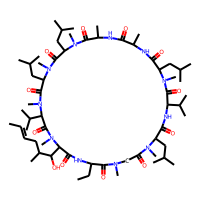
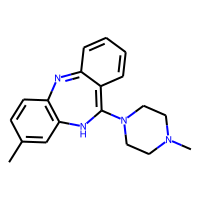
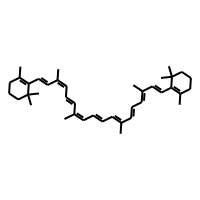
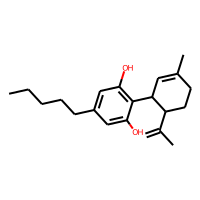

In [ ]:
molecules

In [ ]:
LeadLike

,molecular_weight,n_hba,n_hbd,logp,tpsa,ro5_rule,pfizer_rule,gsk_rule,goldentriangle_rule,qed,...,pains_matched_atoms,alarmnmr_accepted,alarmnmr_matched_names,alarmnmr_matched_atoms,bms_accepted,bms_matched_names,bms_matched_atoms,chelator_accepted,chelator_matched_names,chelator_matched_atoms
0,1201.841368,12.0,5.0,3.26900,278.80,False,False,False,False,0.147925,...,[-],True,[-],[-],True,[-],[-],True,[-],[-]
1,306.184447,4.0,1.0,1.68492,30.87,True,False,True,True,0.869629,...,[-],True,[-],[-],True,[-],[-],True,[-],[-]
2,536.438202,0.0,0.0,12.60580,0.00,False,True,False,False,0.243513,...,[-],True,[-],[-],False,[polyene],"[((9, 10, 11, 12, 13, 14), (11, 12, 13, 14, 15...",True,[-],[-]
3,314.224580,2.0,2.0,5.84650,40.46,True,True,False,False,0.510775,...,[-],False,[c1ccccc1O],"[((11, 9, 8, 7, 6, 5, 10), (22, 7, 6, 5, 10, 9...",True,[-],[-],True,[-],[-]


In [ ]:
matches, unmatches = old_pains_filter(molecules["smiles"])
print(f"Number of compounds with PAINS: {len(matches)}")
print(f"Number of compounds without PAINS: {len(unmatches)}")

  0%|          | 0/4 [00:00<?, ?it/s]

Number of compounds with PAINS: 0
Number of compounds without PAINS: 4
Number of compounds with PAINS: 0
Number of compounds without PAINS: 4


In [ ]:
import os
!git clone https://github.com/TieuLongPhan/Database.git
os.chdir("/content/Database/Training_cheminformatics")

In [ ]:
egfr_data = pd.read_csv("EGFR_compounds_lipinski.csv",
    index_col=0,
)
# Drop unnecessary information
print("Dataframe shape:", egfr_data.shape)
egfr_data.drop(columns=["molecular_weight", "n_hbd", "n_hba", "logp"], inplace=True)
egfr_data.reset_index(drop = True, inplace = True)
egfr_data["smiles"]

Dataframe shape: (4635, 10)


0                       Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1
1                     CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC
2                      CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1
3                     Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1
4                         CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1
                              ...                        
4630                          COc1cc(C=C(C#N)C#N)cc(C)c1O
4631                               O=C(O)/C=C/c1ccc(O)cc1
4632    CN(c1cccnc1)c1cc2c(Nc3ccc(F)c(Cl)c3)c(C#N)cnc2cn1
4633                                N#CC(C#N)Cc1ccc(O)cc1
4634                    O=C(CCc1ccc(O)cc1)c1c(O)cc(O)cc1O
Name: smiles, Length: 4635, dtype: object

In [ ]:
egfr_LeadLike = egfr_data["smiles"].progress_apply(calculate_all, descriptors = False)
egfr_data = pd.concat([egfr_data, egfr_LeadLike], axis = 1)

  0%|          | 0/4635 [00:00<?, ?it/s]

In [ ]:
egfr_data.head(10)

,molecule_chembl_id,IC50,units,smiles,pIC50,ro5_fulfilled,ro5_rule,pfizer_rule,gsk_rule,goldentriangle_rule,...,pains_matched_atoms,alarmnmr_accepted,alarmnmr_matched_names,alarmnmr_matched_atoms,bms_accepted,bms_matched_names,bms_matched_atoms,chelator_accepted,chelator_matched_names,chelator_matched_atoms
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,True,True,True,False,False,...,[-],False,"[c1ccccc1N, c1ccccc1I]","[((6, 5, 4, 3, 2, 1, 21),), ((1, 0),)]",True,[-],[-],True,[-],[-]
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,True,True,True,False,True,...,[-],False,"[[OH]c1cc(N)ccc1_0, Oc1cc2ccccc2cc1, [OH]c1ccc...","[((2, 3, 4, 5, 6, 18, 19, 20),), ((2, 3, 4, 5,...",True,[-],[-],True,[-],[-]
2,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,True,True,True,True,True,...,[-],False,"[c1ccccc1N, c1ccccc1I]","[((7, 8, 9, 10, 11, 12, 14),), ((12, 13),)]",True,[-],[-],True,[-],[-]
3,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,True,True,True,False,True,...,[-],False,"[c1ccccc1N, c1ccccc1I]","[((6, 5, 4, 3, 2, 1, 20),), ((1, 0),)]",True,[-],[-],True,[-],[-]
4,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,True,True,True,True,True,...,[-],False,"[c1ccccc1N, c1ccccc1I]","[((6, 7, 8, 9, 10, 11, 13),), ((11, 12),)]",True,[-],[-],True,[-],[-]
5,CHEMBL176582,0.010,nM,Cn1cnc2cc3ncnc(Nc4cccc(Br)c4)c3cc21,11.000000,True,True,True,False,True,...,[-],False,"[c1ccccc1N, c1ccccc1I]","[((11, 12, 13, 14, 15, 16, 18),), ((16, 17),)]",True,[-],[-],True,[-],[-]
6,CHEMBL29197,0.025,nM,COc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OC,10.602060,True,True,True,False,True,...,[-],False,"[[OH]c1cc(N)ccc1_0, Oc1cc2ccccc2cc1, [OH]c1ccc...","[((1, 2, 3, 4, 5, 17, 18, 19),), ((1, 2, 3, 4,...",True,[-],[-],True,[-],[-]
7,CHEMBL174426,0.025,nM,Cn1cnc2cc3c(Nc4cccc(Br)c4)ncnc3cc21,10.602060,True,True,True,False,True,...,[-],False,"[c1ccccc1N, c1ccccc1I]","[((8, 9, 10, 11, 12, 13, 15),), ((13, 14),)]",True,[-],[-],True,[-],[-]
8,CHEMBL1243316,0.030,nM,C#CCNC/C=C/C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)c(C#N...,10.522879,True,True,False,False,False,...,[-],False,"[Nc1ccc2ncccc2c1, [OH]c1cc(N)ccc1_0, Nc1cc2ccc...","[((9, 10, 30, 29, 28, 27, 26, 23, 13, 12, 11),...",True,[-],[-],True,[-],[-]
9,CHEMBL363815,0.037,nM,C=CC(=O)Nc1ccc2ncnc(Nc3cc(Cl)c(Cl)cc3F)c2c1,10.431798,True,True,True,False,True,...,[-],False,"[Nc1cc2ccccc2cc1, C=CC(=O)N, c1ccccc1N]","[((4, 5, 24, 23, 12, 11, 10, 9, 8, 7, 6),), ((...",False,"[acrylate, halo_acrylate]","[((0, 1, 2, 3),), ((0, 1),)]",True,[-],[-]


In [ ]:
egfr_LeadLike.head(10)

,ro5_rule,pfizer_rule,gsk_rule,goldentriangle_rule,qed,qed_excellent,sascore,sascore_excellent,fsp3,fsp3_excellent,...,pains_matched_atoms,alarmnmr_accepted,alarmnmr_matched_names,alarmnmr_matched_atoms,bms_accepted,bms_matched_names,bms_matched_atoms,chelator_accepted,chelator_matched_names,chelator_matched_atoms
0,True,True,False,False,0.499383,False,2.002069,True,0.000000,False,...,[-],False,"[c1ccccc1N, c1ccccc1I]","[((6, 5, 4, 3, 2, 1, 21),), ((1, 0),)]",True,[-],[-],True,[-],[-]
1,True,True,False,True,0.648824,False,2.105052,True,0.222222,False,...,[-],False,"[[OH]c1cc(N)ccc1_0, Oc1cc2ccccc2cc1, [OH]c1ccc...","[((2, 3, 4, 5, 6, 18, 19, 20),), ((2, 3, 4, 5,...",True,[-],[-],True,[-],[-]
2,True,True,True,True,0.786868,True,2.367369,True,0.133333,False,...,[-],False,"[c1ccccc1N, c1ccccc1I]","[((7, 8, 9, 10, 11, 12, 14),), ((12, 13),)]",True,[-],[-],True,[-],[-]
3,True,True,False,True,0.578561,False,2.403664,True,0.000000,False,...,[-],False,"[c1ccccc1N, c1ccccc1I]","[((6, 5, 4, 3, 2, 1, 20),), ((1, 0),)]",True,[-],[-],True,[-],[-]
4,True,True,True,True,0.768616,True,2.320482,True,0.071429,False,...,[-],False,"[c1ccccc1N, c1ccccc1I]","[((6, 7, 8, 9, 10, 11, 13),), ((11, 12),)]",True,[-],[-],True,[-],[-]
5,True,True,False,True,0.590737,False,2.391051,True,0.062500,False,...,[-],False,"[c1ccccc1N, c1ccccc1I]","[((11, 12, 13, 14, 15, 16, 18),), ((16, 17),)]",True,[-],[-],True,[-],[-]
6,True,True,False,True,0.757494,True,1.993405,True,0.125000,False,...,[-],False,"[[OH]c1cc(N)ccc1_0, Oc1cc2ccccc2cc1, [OH]c1ccc...","[((1, 2, 3, 4, 5, 17, 18, 19),), ((1, 2, 3, 4,...",True,[-],[-],True,[-],[-]
7,True,True,False,True,0.590737,False,2.409331,True,0.062500,False,...,[-],False,"[c1ccccc1N, c1ccccc1I]","[((8, 9, 10, 11, 12, 13, 15),), ((13, 14),)]",True,[-],[-],True,[-],[-]
8,True,False,False,False,0.233348,False,2.965434,True,0.160000,False,...,[-],False,"[Nc1ccc2ncccc2c1, [OH]c1cc(N)ccc1_0, Nc1cc2ccc...","[((9, 10, 30, 29, 28, 27, 26, 23, 13, 12, 11),...",True,[-],[-],True,[-],[-]
9,True,True,False,True,0.499138,False,2.365923,True,0.000000,False,...,[-],False,"[Nc1cc2ccccc2cc1, C=CC(=O)N, c1ccccc1N]","[((4, 5, 24, 23, 12, 11, 10, 9, 8, 7, 6),), ((...",False,"[acrylate, halo_acrylate]","[((0, 1, 2, 3),), ((0, 1),)]",True,[-],[-]
